In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Bắt đầu ở đây

In [2]:
df = pd.read_csv('health_data_proccess.csv')

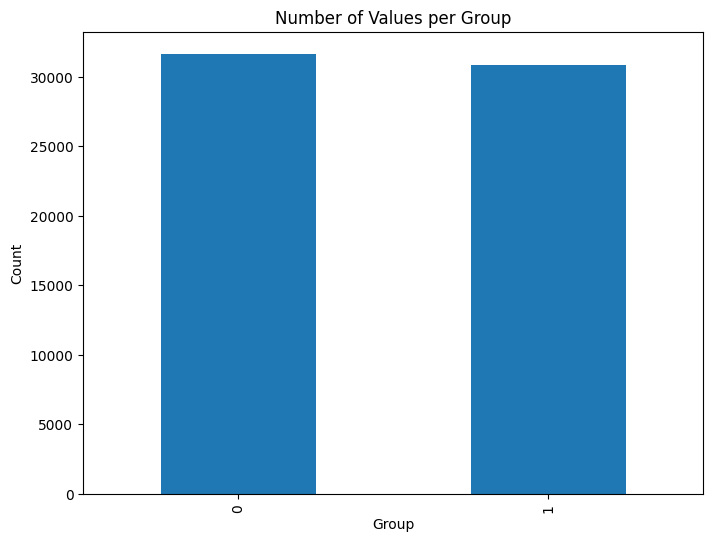

In [3]:
# prompt: draw chart show the number of value of group columns

# Count the occurrences of each group
group_counts = df['group'].value_counts()

# Create a bar chart using matplotlib
plt.figure(figsize=(8, 6))
group_counts.plot(kind='bar')
plt.title('Number of Values per Group')
plt.xlabel('Group')
plt.ylabel('Count')
plt.show()

## HyBrid ACO- Stacking - apply Bayesian hyperparameter optimization - XAI

In [8]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error, accuracy_score
import random
import time

# Load the data
data = pd.read_csv('health_data_proccess.csv')
X = data.drop('group', axis=1)
y = data['group']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Feature names for reference
feature_names = X.columns.tolist()

In [ ]:
class ACOFeatureSelection:

    def __init__(self, n_features, n_ants=10, max_iter=20, alpha=1, beta=2, rho=0.5):
        self.n_features = n_features
        self.n_ants = n_ants
        self.max_iter = max_iter
        self.alpha = alpha  # pheromone importance
        self.beta = beta    # heuristic importance
        self.rho = rho      # pheromone evaporation rate

        # Initialize pheromone trails
        self.pheromone = np.ones((n_features, n_features))
        self.best_subset = None
        self.best_score = float('inf')  # Using MSE, so lower is better
        self.best_accuracy = 0  # Lưu lại độ chính xác tốt nhất
        self.history = []  # Lưu lại lịch sử cho việc vẽ biểu đồ sau này

    def fit(self, X_train, y_train, X_test, y_test, classifier=None):
        # Initialize classifier (using KNN as in the paper)
        if classifier is None:
            classifier = KNeighborsClassifier(n_neighbors=5)

        for iteration in range(self.max_iter):
            all_subsets = []
            all_scores = []
            all_accuracies = []

            # Each ant constructs a solution
            for ant in range(self.n_ants):
                # Randomly select initial feature
                current_feature = random.randint(0, self.n_features - 1)
                visited = [current_feature]
                unvisited = list(set(range(self.n_features)) - set(visited))

                # Continue adding features until stopping criterion is met
                stagnation_counter = 0
                current_score = float('inf')
                current_accuracy = 0

                while unvisited and stagnation_counter < 3:  # As in the paper, stop after 3 non-improving steps
                    # Calculate probabilities for next feature
                    probabilities = self._calculate_probabilities(current_feature, visited, unvisited)

                    # Select next feature
                    next_feature = self._select_next_feature(probabilities, unvisited)
                    visited.append(next_feature)
                    unvisited.remove(next_feature)

                    # Evaluate current subset
                    selected_features = visited.copy()
                    
                    # Handle either DataFrame or numpy array
                    if hasattr(X_train, 'iloc'):  # Pandas DataFrame
                        X_train_selected = X_train.iloc[:, selected_features]
                        X_test_selected = X_test.iloc[:, selected_features]
                    else:  # Numpy array
                        X_train_selected = X_train[:, selected_features]
                        X_test_selected = X_test[:, selected_features]

                    classifier.fit(X_train_selected, y_train)
                    y_pred = classifier.predict(X_test_selected)
                    score = mean_squared_error(y_test, y_pred)
                    accuracy = accuracy_score(y_test, y_pred)

                    # Check if current subset improves performance
                    if score < current_score:
                        current_score = score
                        current_accuracy = accuracy
                        stagnation_counter = 0
                    else:
                        stagnation_counter += 1

                    # Update current feature
                    current_feature = next_feature

                # Save the subset and its score
                all_subsets.append(visited)
                all_scores.append(current_score)
                all_accuracies.append(current_accuracy)

                # Update best global solution
                if current_score < self.best_score:
                    self.best_score = current_score
                    self.best_accuracy = current_accuracy
                    self.best_subset = visited.copy()

            # Update pheromone trails
            self._update_pheromone(all_subsets, all_scores)
            
            # Lưu thông tin lịch sử
            self.history.append({
                'iteration': iteration,
                'best_score': self.best_score,
                'best_accuracy': self.best_accuracy,
                'n_features': len(self.best_subset)
            })

            print(f"Iteration {iteration+1}/{self.max_iter}, Best MSE: {self.best_score:.4f}, "
                  f"Best Accuracy: {self.best_accuracy:.4f}, "
                  f"Features: {len(self.best_subset)}/{self.n_features}")

        return self.best_subset, self.best_score, self.best_accuracy

    def _calculate_probabilities(self, current_feature, visited, unvisited):
        probabilities = {}

        for feature in unvisited:
            # Pheromone between current feature and candidate feature
            tau = self.pheromone[current_feature, feature]

            # Heuristic information (inverse of feature index for simplicity)
            # In a real implementation, this would use classifier performance
            eta = 1.0 / (feature + 1)

            probabilities[feature] = (tau ** self.alpha) * (eta ** self.beta)

        # Normalize probabilities
        total = sum(probabilities.values())
        if total > 0:
            for feature in probabilities:
                probabilities[feature] /= total

        return probabilities

    def _select_next_feature(self, probabilities, unvisited):
        # Roulette wheel selection
        r = random.random()
        cumulative_prob = 0

        for feature in unvisited:
            cumulative_prob += probabilities.get(feature, 0)
            if r <= cumulative_prob:
                return feature

        # If no feature was selected, pick a random one
        return random.choice(unvisited)

    def _update_pheromone(self, all_subsets, all_scores):
        # Evaporate pheromone
        self.pheromone *= (1 - self.rho)

        # Add new pheromone
        for subset, score in zip(all_subsets, all_scores):
            # Normalize the score (lower MSE is better)
            normalized_score = 1.0 / (score + 1e-10)

            # Update pheromone for edges in the subset
            for i in range(len(subset) - 1):
                self.pheromone[subset[i], subset[i+1]] += normalized_score
                self.pheromone[subset[i+1], subset[i]] += normalized_score  # Symmetric update

    def _update_pheromone(self, all_subsets, all_scores):
        # Evaporate pheromone
        self.pheromone *= (1 - self.rho)

        # Add new pheromone
        for subset, score in zip(all_subsets, all_scores):
            # Normalize the score (lower MSE is better)
            normalized_score = 1.0 / (score + 1e-10)

            # Update pheromone for edges in the subset
            for i in range(len(subset) - 1):
                self.pheromone[subset[i], subset[i+1]] += normalized_score
                self.pheromone[subset[i+1], subset[i]] += normalized_score  # Symmetric update
                
    def get_feature_importance(self, feature_names=None):
        """
        Trả về tầm quan trọng của các đặc trưng được chọn dựa trên thứ tự chọn
        """
        if not self.best_subset:
            return {}
            
        importance_dict = {}
        for i, feature_idx in enumerate(self.best_subset):
            # Đặc trưng được chọn sớm hơn sẽ quan trọng hơn
            importance_value = len(self.best_subset) - i
            
            if feature_names and feature_idx < len(feature_names):
                importance_dict[feature_names[feature_idx]] = importance_value
            else:
                importance_dict[feature_idx] = importance_value
                
        return importance_dict

Đang tải dữ liệu từ health_data_proccess.csv...
Dữ liệu có 62502 hàng và 12 cột
Lấy mẫu 10000 dòng...
Đặc trưng: ['age', 'gender', 'height', 'weight', 'bmi', 'ap_hi', 'ap_lo', 'pulse_pressure', 'cholesterol', 'gluc', 'active']
Số lượng đặc trưng: 11
Kích thước dữ liệu huấn luyện: (7000, 11)
Kích thước dữ liệu kiểm tra: (3000, 11)

Đánh giá hiệu suất với tất cả các đặc trưng...
MSE với tất cả các đặc trưng: 0.3123
Độ chính xác với tất cả các đặc trưng: 0.6877
Iteration 1/15, Best MSE: 0.2960, Best Accuracy: 0.7040, Features: 11/11
Iteration 2/15, Best MSE: 0.2960, Best Accuracy: 0.7040, Features: 11/11
Iteration 3/15, Best MSE: 0.2960, Best Accuracy: 0.7040, Features: 11/11
Iteration 4/15, Best MSE: 0.2960, Best Accuracy: 0.7040, Features: 11/11
Iteration 5/15, Best MSE: 0.2960, Best Accuracy: 0.7040, Features: 11/11
Iteration 6/15, Best MSE: 0.2937, Best Accuracy: 0.7063, Features: 6/11
Iteration 7/15, Best MSE: 0.2937, Best Accuracy: 0.7063, Features: 6/11
Iteration 8/15, Best MSE: 0.

<Figure size 1200x600 with 0 Axes>

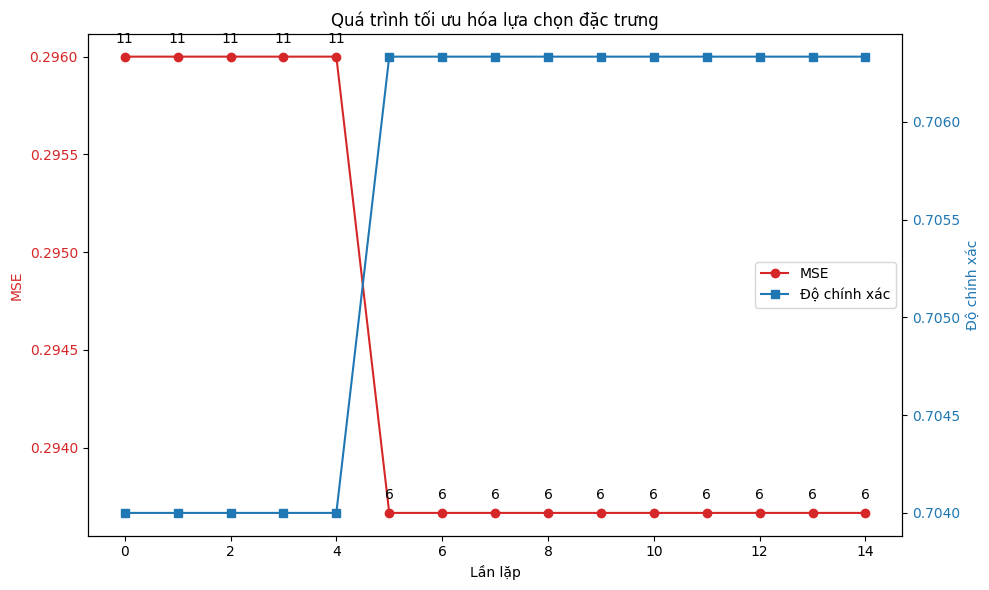

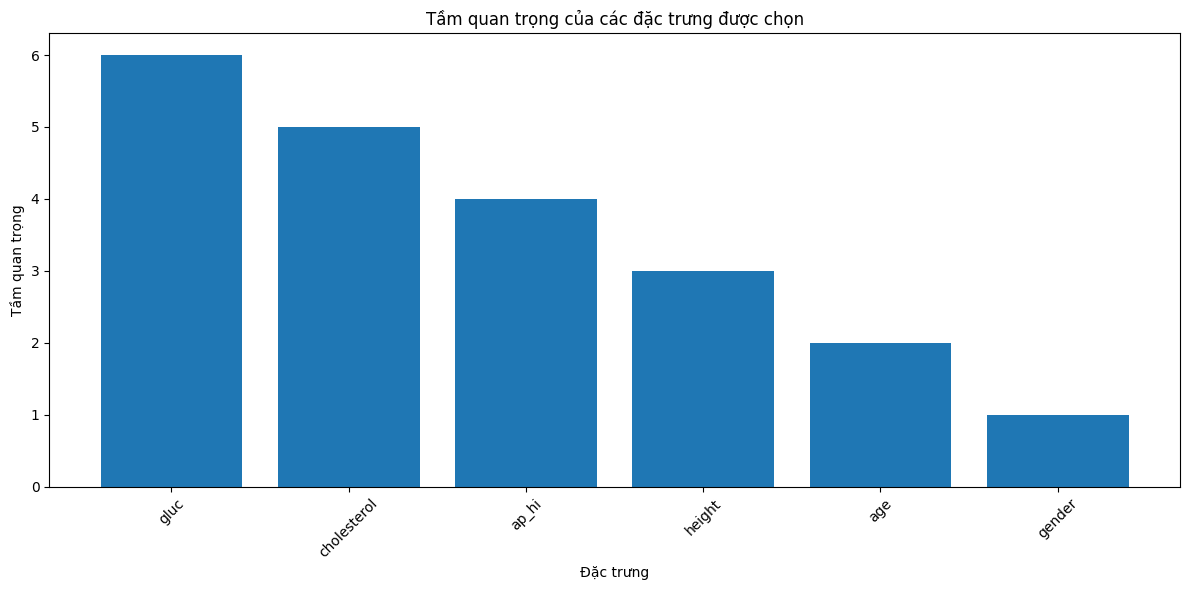


Đã lưu danh sách đặc trưng được chọn vào 'selected_features.csv'


In [11]:
# Hàm tải dữ liệu
def load_data(file_path, sample_size=None):
    """Tải dữ liệu từ CSV"""
    print(f"Đang tải dữ liệu từ {file_path}...")
    data = pd.read_csv(file_path)
    
    print(f"Dữ liệu có {data.shape[0]} hàng và {data.shape[1]} cột")
    
    # Nếu cần lấy mẫu nhỏ hơn
    if sample_size and sample_size < len(data):
        print(f"Lấy mẫu {sample_size} dòng...")
        data = data.sample(sample_size, random_state=42)
    
    return data

# Hàm đánh giá tất cả đặc trưng
def evaluate_full_features(X_train, X_test, y_train, y_test):
    """Đánh giá hiệu suất với tất cả đặc trưng"""
    print("\nĐánh giá hiệu suất với tất cả các đặc trưng...")
    clf = KNeighborsClassifier(n_neighbors=5)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"MSE với tất cả các đặc trưng: {mse:.4f}")
    print(f"Độ chính xác với tất cả các đặc trưng: {accuracy:.4f}")
    return mse, accuracy

# Hàm vẽ kết quả
def plot_results(aco, feature_names):
    """Vẽ biểu đồ kết quả tối ưu hóa"""
    if not aco.history:
        print("Không có dữ liệu lịch sử để vẽ")
        return
        
    # Vẽ biểu đồ MSE và độ chính xác theo thời gian
    plt.figure(figsize=(12, 6))
    iterations = [h['iteration'] for h in aco.history]
    mse_values = [h['best_score'] for h in aco.history]
    accuracy_values = [h['best_accuracy'] for h in aco.history]
    n_features = [h['n_features'] for h in aco.history]
    
    # Tạo biểu đồ với 2 trục y
    fig, ax1 = plt.subplots(figsize=(10, 6))
    
    color = 'tab:red'
    ax1.set_xlabel('Lần lặp')
    ax1.set_ylabel('MSE', color=color)
    line1 = ax1.plot(iterations, mse_values, color=color, marker='o', label='MSE')
    ax1.tick_params(axis='y', labelcolor=color)
    
    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('Độ chính xác', color=color)
    line2 = ax2.plot(iterations, accuracy_values, color=color, marker='s', label='Độ chính xác')
    ax2.tick_params(axis='y', labelcolor=color)
    
    # Thêm số lượng đặc trưng
    for i, nf in enumerate(n_features):
        ax1.annotate(f"{nf}", (iterations[i], mse_values[i]), 
                    textcoords="offset points", xytext=(0,10), ha='center')
    
    # Tạo legend cho cả hai trục
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    plt.legend(lines, labels, loc='center right')
    
    plt.title('Quá trình tối ưu hóa lựa chọn đặc trưng')
    plt.tight_layout()
    plt.savefig('aco_optimization.png')
    plt.show()
    
    # Vẽ biểu đồ tầm quan trọng của đặc trưng
    importance_dict = aco.get_feature_importance(feature_names)
    
    plt.figure(figsize=(12, 6))
    features = list(importance_dict.keys())
    values = list(importance_dict.values())
    
    # Sắp xếp theo tầm quan trọng
    sorted_indices = np.argsort(values)[::-1]  # Đảo ngược để lấy thứ tự giảm dần
    sorted_features = [features[i] for i in sorted_indices]
    sorted_values = [values[i] for i in sorted_indices]
    
    plt.bar(sorted_features, sorted_values)
    plt.xlabel('Đặc trưng')
    plt.ylabel('Tầm quan trọng')
    plt.title('Tầm quan trọng của các đặc trưng được chọn')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('feature_importance.png')
    plt.show()

# Hàm chính để chạy quá trình lựa chọn đặc trưng
def run_feature_selection(data_path, sample_size=None, n_ants=10, max_iter=15):
    """
    Chạy quá trình lựa chọn đặc trưng với ACO
    
    Tham số:
    ---------
    data_path : str
        Đường dẫn đến file dữ liệu
    sample_size : int, tùy chọn
        Kích thước mẫu để giảm thời gian chạy, mặc định là None (sử dụng toàn bộ dữ liệu)
    n_ants : int
        Số lượng kiến, mặc định là 10
    max_iter : int
        Số lần lặp tối đa, mặc định là 15
    """
    # Tải dữ liệu
    data = load_data(data_path, sample_size)
    
    # Chia dữ liệu thành đặc trưng và nhãn
    X = data.drop('group', axis=1)
    y = data['group']
    feature_names = X.columns.tolist()
    
    print(f"Đặc trưng: {feature_names}")
    print(f"Số lượng đặc trưng: {len(feature_names)}")
    
    # Chia dữ liệu thành tập huấn luyện và kiểm tra
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    print(f"Kích thước dữ liệu huấn luyện: {X_train.shape}")
    print(f"Kích thước dữ liệu kiểm tra: {X_test.shape}")
    
    # Đánh giá hiệu suất với tất cả đặc trưng
    full_mse, full_accuracy = evaluate_full_features(X_train, X_test, y_train, y_test)
    
    # Khởi tạo và chạy ACO
    start_time = time.time()
    
    aco = ACOFeatureSelection(
        n_features=len(feature_names),
        n_ants=n_ants,
        max_iter=max_iter,
        alpha=1,
        beta=2,
        rho=0.5
    )
    
    selected_features, best_mse, best_accuracy = aco.fit(X_train, y_train, X_test, y_test)
    
    elapsed_time = time.time() - start_time
    print(f"\nThời gian chạy: {elapsed_time:.2f} giây")
    
    # Hiển thị các đặc trưng được chọn
    selected_names = [feature_names[i] for i in selected_features]
    print(f"\nĐặc trưng được chọn ({len(selected_features)}/{len(feature_names)}):")
    for i, name in enumerate(selected_names):
        print(f"{i+1}. {name}")
    
    # So sánh kết quả
    print("\n=== So sánh kết quả ===")
    print(f"Tất cả các đặc trưng ({len(feature_names)}): MSE={full_mse:.4f}, Accuracy={full_accuracy:.4f}")
    print(f"Đặc trưng được chọn ({len(selected_features)}): MSE={best_mse:.4f}, Accuracy={best_accuracy:.4f}")
    print(f"Giảm số lượng đặc trưng: {len(feature_names) - len(selected_features)} ({(1 - len(selected_features)/len(feature_names))*100:.1f}%)")
    
    # Vẽ biểu đồ kết quả
    plot_results(aco, feature_names)
    
    # Lưu kết quả vào file CSV
    result_df = pd.DataFrame({
        'feature_name': [feature_names[i] for i in selected_features],
        'feature_index': selected_features,
        'selection_order': range(1, len(selected_features) + 1)
    })
    result_df.to_csv('selected_features.csv', index=False)
    print("\nĐã lưu danh sách đặc trưng được chọn vào 'selected_features.csv'")
    
    return aco, selected_features, best_mse, best_accuracy

# Chạy quá trình lựa chọn đặc trưng
if __name__ == "__main__":
    # Thay đổi các tham số tùy thuộc vào nhu cầu
    aco, selected_features, best_mse, best_accuracy = run_feature_selection(
        data_path='health_data_proccess.csv',  # Đường dẫn đến file dữ liệu
        sample_size=10000,  # Đặt None để sử dụng toàn bộ dữ liệu, hoặc một số nhỏ hơn để chạy nhanh hơn
        n_ants=15,          # Số lượng kiến
        max_iter=15         # Số lần lặp tối đa
    )

## Model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import lightgbm as lgbm

In [2]:
df_1 = pd.read_csv('health_data_proccess_ACO.csv')

[LightGBM] [Info] Number of positive: 21607, number of negative: 22144
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001187 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 152
[LightGBM] [Info] Number of data points in the train set: 43751, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493863 -> initscore=-0.024549
[LightGBM] [Info] Start training from score -0.024549
Độ chính xác: 0.7308

Báo cáo phân loại:
              precision    recall  f1-score   support

           0       0.71      0.78      0.75      9490
           1       0.75      0.68      0.71      9261

    accuracy                           0.73     18751
   macro avg       0.73      0.73      0.73     18751
weighted avg       0.73      0.73      0.73     18751


Ma trận nhầm lẫn:
[[7390 2100]
 [2948 6313]]
[LightGBM] [Info] Number of po

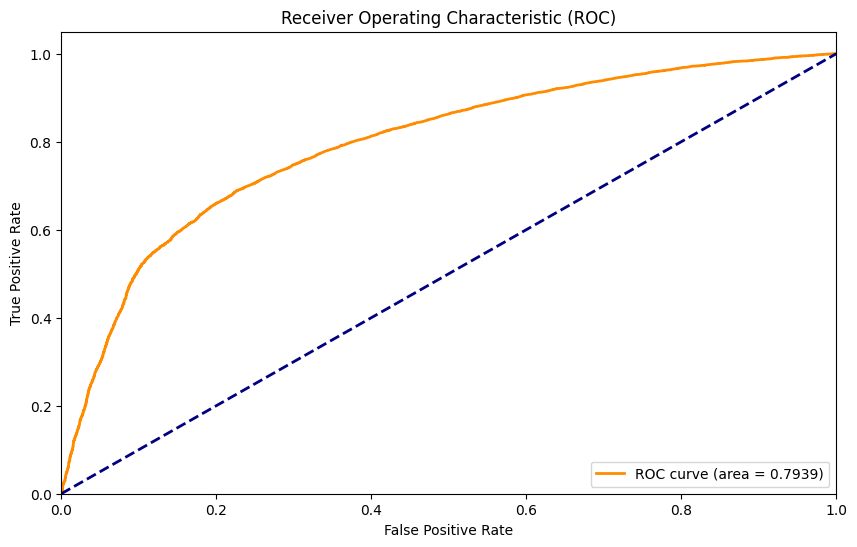

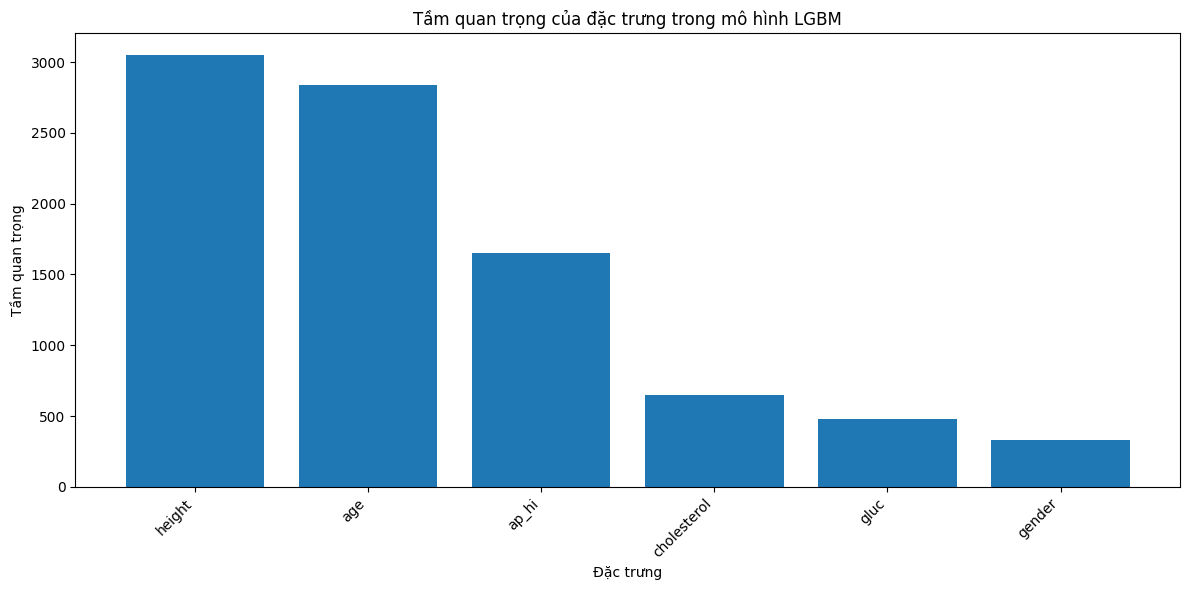

In [6]:
X = df_1.drop('group', axis=1)
y = df_1['group']  # Biến mục tiêu (0: Khỏe mạnh, 1: AMI)

# 2. Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# 3. Định nghĩa các tham số cho mô hình LGBM (dựa trên bài báo)
params = {
    'n_estimators': 300,
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,
    'num_leaves': 31,
    'min_child_weight': 0.001,
    'min_child_samples': 20,
    'subsample': 1.0,
    'colsample_bytree': 1.0,
    'random_state': 42
}

# 4. Huấn luyện mô hình LGBM
model = lgbm.LGBMClassifier(**params)
model.fit(X_train, y_train)

# 5. Đánh giá mô hình
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# Độ chính xác
accuracy = accuracy_score(y_test, y_pred)
print(f"Độ chính xác: {accuracy:.4f}")

# Báo cáo phân loại
print("\nBáo cáo phân loại:")
print(classification_report(y_test, y_pred))

# Ma trận nhầm lẫn
cm = confusion_matrix(y_test, y_pred)
print("\nMa trận nhầm lẫn:")
print(cm)

# 6. Đánh giá bằng cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
print(f"\nĐộ chính xác trung bình qua 5-fold CV: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

# 7. Vẽ đường cong ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.savefig('roc_curve.png')
plt.show()

# # 8. Lưu mô hình
# import joblib
# joblib.dump(model, 'lgbm_model.pkl')

# In ra tầm quan trọng đặc trưng dựa trên mô hình
feature_importance = model.feature_importances_
feature_names = X.columns

# Sắp xếp tầm quan trọng
sorted_indices = np.argsort(feature_importance)[::-1]
sorted_features = [feature_names[i] for i in sorted_indices]
sorted_importance = feature_importance[sorted_indices]

# Vẽ biểu đồ tầm quan trọng
plt.figure(figsize=(12, 6))
plt.bar(range(len(sorted_importance)), sorted_importance)
plt.xticks(range(len(sorted_importance)), sorted_features, rotation=45, ha='right')
plt.xlabel('Đặc trưng')
plt.ylabel('Tầm quan trọng')
plt.title('Tầm quan trọng của đặc trưng trong mô hình LGBM')
plt.tight_layout()
plt.savefig('feature_importance.png')
plt.show()

In [6]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
# Định nghĩa không gian tìm kiếm
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [31, 50, 100],
    'min_child_samples': [10, 20, 30],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Tìm kiếm lưới với cross-validation
grid_search = GridSearchCV(
    lgbm.LGBMClassifier(random_state=42), 
    param_grid, 
    cv=5, 
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Huấn luyện và tìm kiếm tham số tốt nhất
grid_search.fit(X_train, y_train)

# In ra tham số tốt nhất
print("Các tham số tối ưu:", grid_search.best_params_)
print("Độ chính xác tốt nhất:", grid_search.best_score_)

# Sử dụng mô hình tốt nhất
best_model = grid_search.best_estimator_

# Đánh giá mô hình tốt nhất trên tập kiểm tra
y_pred_best = best_model.predict(X_test)
accuracy_best = accuracy_score(y_test, y_pred_best)
print(f"Độ chính xác với mô hình tốt nhất: {accuracy_best:.4f}")

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


KeyboardInterrupt: 

In [4]:
X = df_1.drop('group', axis=1)
y = df_1['group']  # Biến mục tiêu (0: Khỏe mạnh, 1: AMI)


# 2. Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print("===== KẾT HỢP MÔ HÌNH LGBM THEO STACKING =====")

# Định nghĩa các tham số cho LGBM
params = {
    'n_estimators': 300,
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,
    'num_leaves': 31,
    'min_child_weight': 0.001,
    'min_child_samples': 20,
    'subsample': 1.0,
    'colsample_bytree': 1.0,
    'random_state': 42
}

# ===== PHƯƠNG ÁN 1: LGBM LÀM MÔ HÌNH CẤP 1 =====
print("\n==== PHƯƠNG ÁN 1: LGBM + DECISION TREE ====")
# 1️⃣ Huấn luyện mô hình LGBM
lgbm_model = lgbm.LGBMClassifier(**params)
lgbm_model.fit(X_train, y_train)

# 2️⃣ Dự đoán xác suất từ LGBM
lgbm_train_proba = lgbm_model.predict_proba(X_train)[:, 1].reshape(-1, 1)
lgbm_test_proba = lgbm_model.predict_proba(X_test)[:, 1].reshape(-1, 1)

# 3️⃣ Gắn xác suất vào dữ liệu gốc
X_train_hybrid1 = np.hstack((X_train, lgbm_train_proba))
X_test_hybrid1 = np.hstack((X_test, lgbm_test_proba))

# 4️⃣ Huấn luyện Decision Tree trên dữ liệu mở rộng
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train_hybrid1, y_train)

# 5️⃣ Dự đoán và đánh giá mô hình Hybrid 1
y_pred_hybrid1 = dt_model.predict(X_test_hybrid1)
y_prob_hybrid1 = dt_model.predict_proba(X_test_hybrid1)[:, 1]

# Tính độ chính xác và AUC
accuracy_hybrid1 = accuracy_score(y_test, y_pred_hybrid1)
fpr1, tpr1, _ = roc_curve(y_test, y_prob_hybrid1)
roc_auc1 = auc(fpr1, tpr1)

print(f"Độ chính xác của LGBM + Decision Tree: {accuracy_hybrid1:.4f}")
print(f"AUC-ROC của LGBM + Decision Tree: {roc_auc1:.4f}")
print("\nBáo cáo phân loại:")
print(classification_report(y_test, y_pred_hybrid1))

# ===== PHƯƠNG ÁN 2: LGBM LÀM MÔ HÌNH CẤP 2 =====
print("\n==== PHƯƠNG ÁN 2: RANDOM FOREST + LGBM ====")
# 1️⃣ Huấn luyện mô hình Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# 2️⃣ Dự đoán xác suất từ Random Forest
rf_train_proba = rf_model.predict_proba(X_train)[:, 1].reshape(-1, 1)
rf_test_proba = rf_model.predict_proba(X_test)[:, 1].reshape(-1, 1)

# 3️⃣ Gắn xác suất vào dữ liệu gốc
X_train_hybrid2 = np.hstack((X_train, rf_train_proba))
X_test_hybrid2 = np.hstack((X_test, rf_test_proba))

# 4️⃣ Huấn luyện LGBM trên dữ liệu mở rộng
lgbm_model2 = lgbm.LGBMClassifier(**params)
lgbm_model2.fit(X_train_hybrid2, y_train)

# 5️⃣ Dự đoán và đánh giá mô hình Hybrid 2
y_pred_hybrid2 = lgbm_model2.predict(X_test_hybrid2)
y_prob_hybrid2 = lgbm_model2.predict_proba(X_test_hybrid2)[:, 1]

# Tính độ chính xác và AUC
accuracy_hybrid2 = accuracy_score(y_test, y_pred_hybrid2)
fpr2, tpr2, _ = roc_curve(y_test, y_prob_hybrid2)
roc_auc2 = auc(fpr2, tpr2)

print(f"Độ chính xác của Random Forest + LGBM: {accuracy_hybrid2:.4f}")
print(f"AUC-ROC của Random Forest + LGBM: {roc_auc2:.4f}")
print("\nBáo cáo phân loại:")
print(classification_report(y_test, y_pred_hybrid2))

===== KẾT HỢP MÔ HÌNH LGBM THEO STACKING =====

==== PHƯƠNG ÁN 1: LGBM + DECISION TREE ====
[LightGBM] [Info] Number of positive: 21607, number of negative: 22144
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006888 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 152
[LightGBM] [Info] Number of data points in the train set: 43751, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493863 -> initscore=-0.024549
[LightGBM] [Info] Start training from score -0.024549


NameError: name 'DecisionTreeClassifier' is not defined

## ACO + LGBM

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgbm
from sklearn.model_selection import train_test_split, cross_val_score, KFold, cross_validate
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                            roc_auc_score, confusion_matrix, classification_report, 
                            roc_curve, auc, precision_recall_curve, average_precision_score)
import time

In [6]:
# Đặt style cho biểu đồ
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")
plt.rcParams.update({'font.size': 12})

df_original = pd.read_csv('health_data_proccess.csv')
df_aco = pd.read_csv('health_data_proccess_ACO.csv')

In [8]:
# Chỉ định các đặc trưng và biến mục tiêu
# Đối với dữ liệu ban đầu
X_original = df_original.drop('group', axis=1)
all_features = X_original.columns.tolist()
y_original = df_original['group']

# Đối với dữ liệu sau ACO
X_aco = df_aco.drop('group', axis=1)
selected_features = X_aco.columns.tolist()
y_aco = df_aco['group']

In [9]:
print(f"\nSố đặc trưng ban đầu: {len(all_features)}")
print(f"Các đặc trưng ban đầu: {all_features}")
print(f"Số đặc trưng sau ACO: {len(selected_features)}")
print(f"Các đặc trưng sau ACO: {selected_features}")
print(f"Đặc trưng bị loại bỏ bởi ACO: {list(set(all_features) - set(selected_features))}")


Số đặc trưng ban đầu: 11
Các đặc trưng ban đầu: ['age', 'gender', 'height', 'weight', 'bmi', 'ap_hi', 'ap_lo', 'pulse_pressure', 'cholesterol', 'gluc', 'active']
Số đặc trưng sau ACO: 6
Các đặc trưng sau ACO: ['age', 'gender', 'height', 'ap_hi', 'cholesterol', 'gluc']
Đặc trưng bị loại bỏ bởi ACO: ['weight', 'bmi', 'ap_lo', 'active', 'pulse_pressure']


In [10]:
# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_orig_train, X_orig_test, y_orig_train, y_orig_test = train_test_split(
    X_original, y_original, test_size=0.3, random_state=42, stratify=y_original)

X_aco_train, X_aco_test, y_aco_train, y_aco_test = train_test_split(
    X_aco, y_aco, test_size=0.3, random_state=42, stratify=y_aco)

In [11]:
# Kiểm tra phân phối lớp trong tập huấn luyện và kiểm tra
print("\nPhân phối lớp trong tập dữ liệu:")
print(f"Tập huấn luyện ban đầu: {pd.Series(y_orig_train).value_counts().to_dict()}")
print(f"Tập kiểm tra ban đầu: {pd.Series(y_orig_test).value_counts().to_dict()}")
print(f"Tập huấn luyện sau ACO: {pd.Series(y_aco_train).value_counts().to_dict()}")
print(f"Tập kiểm tra sau ACO: {pd.Series(y_aco_test).value_counts().to_dict()}")


Phân phối lớp trong tập dữ liệu:
Tập huấn luyện ban đầu: {0: 22144, 1: 21607}
Tập kiểm tra ban đầu: {0: 9490, 1: 9261}
Tập huấn luyện sau ACO: {0: 22144, 1: 21607}
Tập kiểm tra sau ACO: {0: 9490, 1: 9261}


In [12]:
# Định nghĩa các tham số tối ưu cho LGBM (có thể thay đổi dựa trên kết quả từ phần tối ưu hóa siêu tham số trước đó)
best_params = {
    'n_estimators': 300,
    'learning_rate': 0.1,
    'num_leaves': 31,
    'max_depth': -1,
    'min_child_samples': 20,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': 42
}

In [14]:
# Đánh giá hiệu suất trên tập dữ liệu ban đầu
start_time_orig = time.time()
model_orig = lgbm.LGBMClassifier(**best_params)
model_orig.fit(X_orig_train, y_orig_train)
train_time_orig = time.time() - start_time_orig

# Dự đoán trên tập kiểm tra
y_orig_pred = model_orig.predict(X_orig_test)
y_orig_prob = model_orig.predict_proba(X_orig_test)[:, 1]

# Đánh giá hiệu suất trên tập dữ liệu sau ACO
start_time_aco = time.time()
model_aco = lgbm.LGBMClassifier(**best_params)
model_aco.fit(X_aco_train, y_aco_train)
train_time_aco = time.time() - start_time_aco

# Dự đoán trên tập kiểm tra
y_aco_pred = model_aco.predict(X_aco_test)
y_aco_prob = model_aco.predict_proba(X_aco_test)[:, 1]


[LightGBM] [Info] Number of positive: 21607, number of negative: 22144
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001253 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 606
[LightGBM] [Info] Number of data points in the train set: 43751, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493863 -> initscore=-0.024549
[LightGBM] [Info] Start training from score -0.024549
[LightGBM] [Info] Number of positive: 21607, number of negative: 22144
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000917 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 152
[LightGBM] [Info] Number of data points in the train set: 43751, number of used features: 6
[LightGBM] [Info] [bi

In [15]:
# Tính các chỉ số hiệu suất
metrics_orig = {
    'Accuracy': accuracy_score(y_orig_test, y_orig_pred),
    'Precision': precision_score(y_orig_test, y_orig_pred),
    'Recall': recall_score(y_orig_test, y_orig_pred),
    'F1 Score': f1_score(y_orig_test, y_orig_pred),
    'ROC AUC': roc_auc_score(y_orig_test, y_orig_prob)
}

metrics_aco = {
    'Accuracy': accuracy_score(y_aco_test, y_aco_pred),
    'Precision': precision_score(y_aco_test, y_aco_pred),
    'Recall': recall_score(y_aco_test, y_aco_pred),
    'F1 Score': f1_score(y_aco_test, y_aco_pred),
    'ROC AUC': roc_auc_score(y_aco_test, y_aco_prob)
}

In [16]:
# Hiển thị kết quả so sánh
print("\n===== Kết quả đánh giá hiệu suất =====")
print(f"Thời gian huấn luyện (ban đầu): {train_time_orig:.2f} giây")
print(f"Thời gian huấn luyện (sau ACO): {train_time_aco:.2f} giây")
print(f"Chênh lệch thời gian: {train_time_orig - train_time_aco:.2f} giây ({(train_time_orig - train_time_aco) / train_time_orig * 100:.2f}%)")

# Tạo bảng so sánh
comparison_table = pd.DataFrame({
    'Original Model': metrics_orig,
    'ACO-LGBM Model': metrics_aco
})

# Thêm cột % cải thiện
comparison_table['Improvement (%)'] = ((comparison_table['ACO-LGBM Model'] - comparison_table['Original Model']) / comparison_table['Original Model'] * 100).round(2)

print("\nBảng so sánh hiệu suất:")
print(comparison_table)

# Cross-validation để đánh giá mức độ ổn định của mô hình
print("\nĐánh giá bằng cross-validation...")
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Đánh giá mô hình ban đầu
cv_orig = cross_val_score(lgbm.LGBMClassifier(**best_params), X_original, y_original, cv=cv, scoring='accuracy')

# Đánh giá mô hình sau ACO
cv_aco = cross_val_score(lgbm.LGBMClassifier(**best_params), X_aco, y_aco, cv=cv, scoring='accuracy')

print(f"CV Accuracy (ban đầu): {cv_orig.mean():.4f} ± {cv_orig.std():.4f}")
print(f"CV Accuracy (sau ACO): {cv_aco.mean():.4f} ± {cv_aco.std():.4f}")
print(f"Chênh lệch: {cv_aco.mean() - cv_orig.mean():.4f} ({(cv_aco.mean() - cv_orig.mean()) / cv_orig.mean() * 100:.2f}%)")



===== Kết quả đánh giá hiệu suất =====
Thời gian huấn luyện (ban đầu): 0.44 giây
Thời gian huấn luyện (sau ACO): 0.21 giây
Chênh lệch thời gian: 0.23 giây (52.26%)

Bảng so sánh hiệu suất:
           Original Model  ACO-LGBM Model  Improvement (%)
Accuracy         0.732281        0.731481            -0.11
Precision        0.750858        0.753661             0.37
Recall           0.685347        0.677897            -1.09
F1 Score         0.716608        0.713774            -0.40
ROC AUC          0.796123        0.794567            -0.20

Đánh giá bằng cross-validation...
[LightGBM] [Info] Number of positive: 24688, number of negative: 25313
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001441 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 614
[LightGBM] [Info] Number of data points in the train set: 50001, number of used features: 1

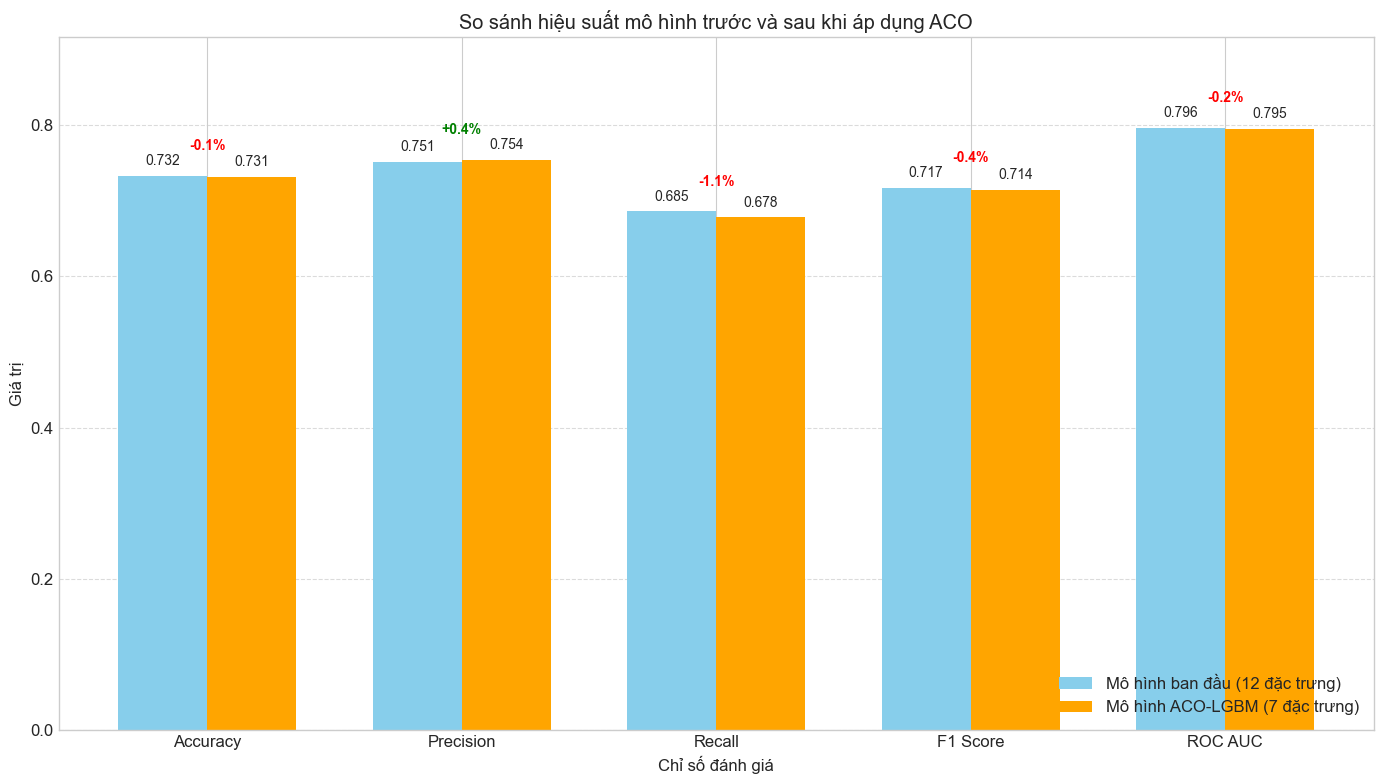

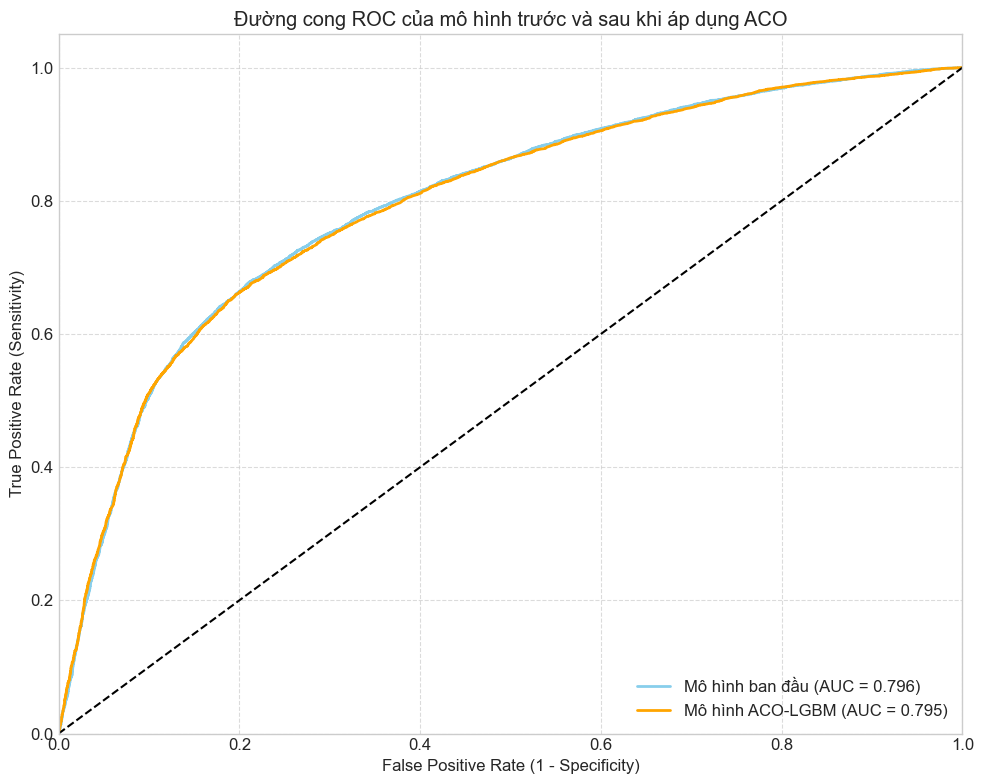

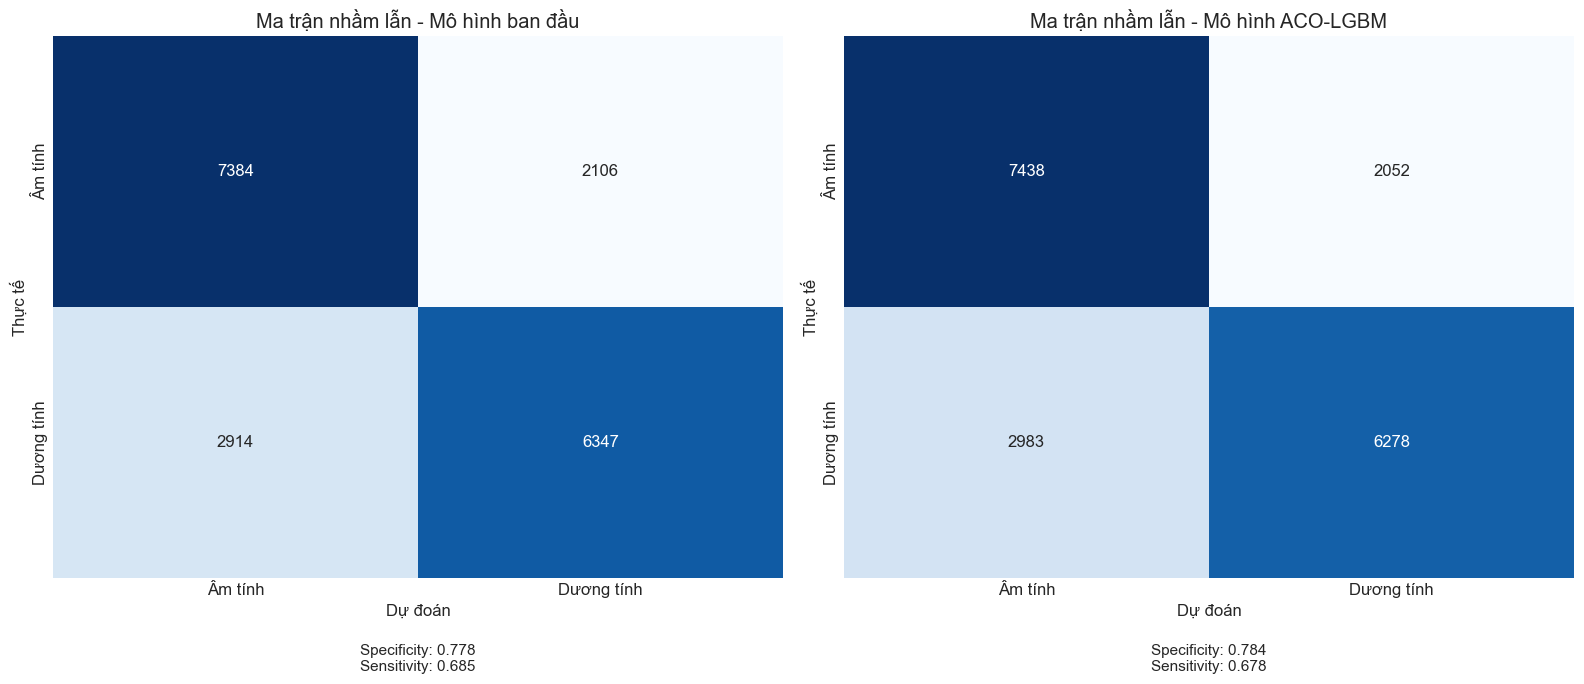

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_17032\3196127864.py:110: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([cv_orig, cv_aco], labels=['Mô hình ban đầu', 'Mô hình ACO-LGBM'])


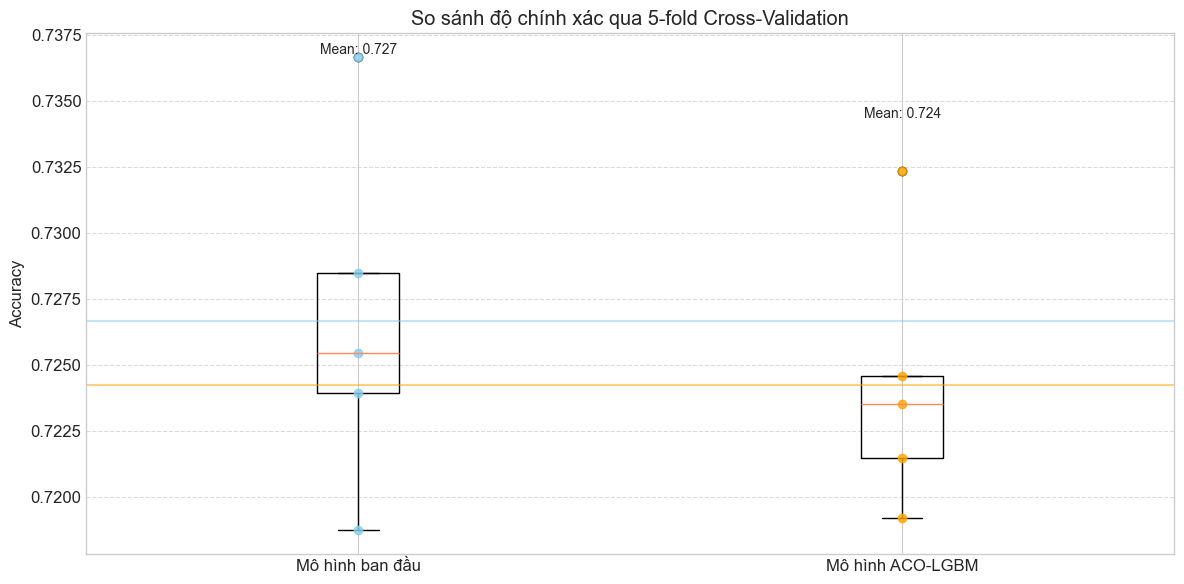

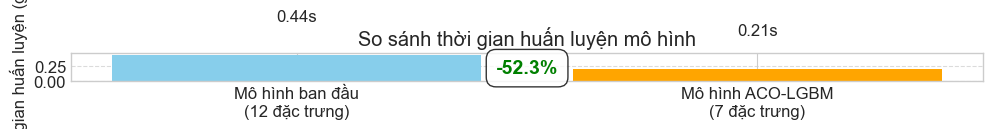

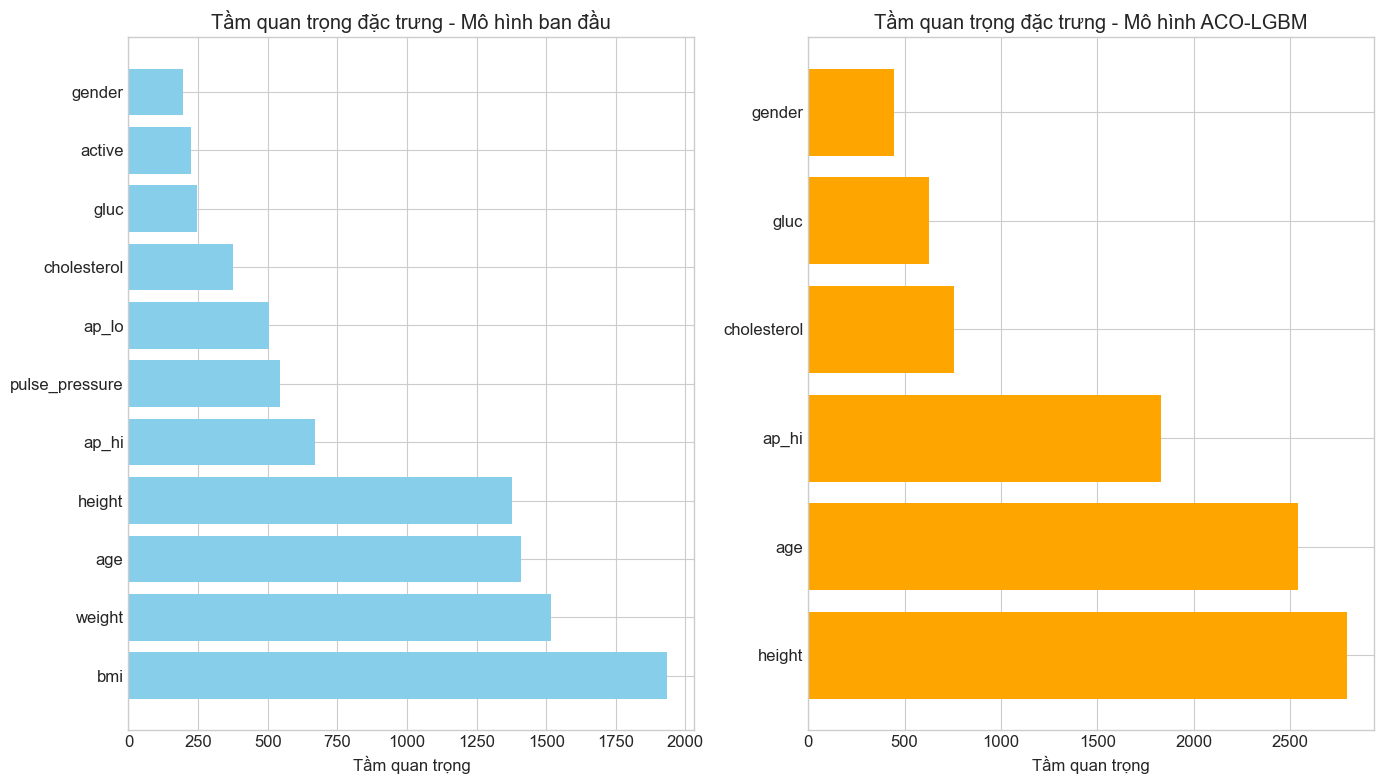

In [ ]:
# ===== BIỂU ĐỒ SO SÁNH HIỆU SUẤT =====

# 1. Biểu đồ so sánh các chỉ số
plt.figure(figsize=(14, 8))
metrics = list(metrics_orig.keys())
metrics_values_orig = [metrics_orig[m] for m in metrics]
metrics_values_aco = [metrics_aco[m] for m in metrics]

x = np.arange(len(metrics))
width = 0.35

plt.bar(x - width/2, metrics_values_orig, width, label='Mô hình ban đầu (12 đặc trưng)', color='skyblue')
plt.bar(x + width/2, metrics_values_aco, width, label='Mô hình ACO-LGBM (7 đặc trưng)', color='orange')

for i, v in enumerate(metrics_values_orig):
    plt.text(i - width/2, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontsize=10)

for i, v in enumerate(metrics_values_aco):
    plt.text(i + width/2, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontsize=10)
    
    # Thêm % cải thiện
    improvement = (metrics_values_aco[i] - metrics_values_orig[i]) / metrics_values_orig[i] * 100
    plt.text(i, max(metrics_values_orig[i], metrics_values_aco[i]) + 0.03, 
             f"{'+' if improvement >= 0 else ''}{improvement:.1f}%", 
             ha='center', va='bottom', fontsize=10, fontweight='bold',
             color='green' if improvement >= 0 else 'red')

plt.xlabel('Chỉ số đánh giá')
plt.ylabel('Giá trị')
plt.title('So sánh hiệu suất mô hình trước và sau khi áp dụng ACO')
plt.xticks(x, metrics)
plt.ylim(0, max(max(metrics_values_orig), max(metrics_values_aco)) * 1.15)
plt.legend(loc='lower right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
#plt.savefig('aco_lgbm_metrics_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# 2. Biểu đồ so sánh ROC curve
plt.figure(figsize=(10, 8))
# Tính ROC curve cho mô hình ban đầu
fpr_orig, tpr_orig, _ = roc_curve(y_orig_test, y_orig_prob)
roc_auc_orig = auc(fpr_orig, tpr_orig)

# Tính ROC curve cho mô hình sau ACO
fpr_aco, tpr_aco, _ = roc_curve(y_aco_test, y_aco_prob)
roc_auc_aco = auc(fpr_aco, tpr_aco)

plt.plot(fpr_orig, tpr_orig, linestyle='-', linewidth=2, 
         label=f'Mô hình ban đầu (AUC = {roc_auc_orig:.3f})', color='skyblue')
plt.plot(fpr_aco, tpr_aco, linestyle='-', linewidth=2, 
         label=f'Mô hình ACO-LGBM (AUC = {roc_auc_aco:.3f})', color='orange')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Đường cong ROC của mô hình trước và sau khi áp dụng ACO')
plt.legend(loc='lower right')
plt.grid(linestyle='--', alpha=0.7)
plt.tight_layout()
#plt.savefig('aco_lgbm_roc_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# 3. Biểu đồ so sánh ma trận nhầm lẫn
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Ma trận nhầm lẫn cho mô hình ban đầu
cm_orig = confusion_matrix(y_orig_test, y_orig_pred)
cm_orig_norm = cm_orig.astype('float') / cm_orig.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_orig_norm, annot=cm_orig, fmt='d', cmap='Blues', cbar=False, ax=axes[0])
axes[0].set_title('Ma trận nhầm lẫn - Mô hình ban đầu')
axes[0].set_xlabel('Dự đoán')
axes[0].set_ylabel('Thực tế')
axes[0].set_xticklabels(['Âm tính', 'Dương tính'])
axes[0].set_yticklabels(['Âm tính', 'Dương tính'])

# Thêm các chỉ số
tn, fp, fn, tp = cm_orig.ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)
axes[0].text(0.5, -0.15, f"Specificity: {specificity:.3f}\nSensitivity: {sensitivity:.3f}", 
             ha='center', va='center', transform=axes[0].transAxes, fontsize=11)

# Ma trận nhầm lẫn cho mô hình sau ACO
cm_aco = confusion_matrix(y_aco_test, y_aco_pred)
cm_aco_norm = cm_aco.astype('float') / cm_aco.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_aco_norm, annot=cm_aco, fmt='d', cmap='Blues', cbar=False, ax=axes[1])
axes[1].set_title('Ma trận nhầm lẫn - Mô hình ACO-LGBM')
axes[1].set_xlabel('Dự đoán')
axes[1].set_ylabel('Thực tế')
axes[1].set_xticklabels(['Âm tính', 'Dương tính'])
axes[1].set_yticklabels(['Âm tính', 'Dương tính'])

# Thêm các chỉ số
tn, fp, fn, tp = cm_aco.ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)
axes[1].text(0.5, -0.15, f"Specificity: {specificity:.3f}\nSensitivity: {sensitivity:.3f}", 
             ha='center', va='center', transform=axes[1].transAxes, fontsize=11)

plt.tight_layout()
#plt.savefig('aco_lgbm_confusion_matrix_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# 4. Biểu đồ so sánh cross-validation
plt.figure(figsize=(12, 6))
plt.boxplot([cv_orig, cv_aco], labels=['Mô hình ban đầu', 'Mô hình ACO-LGBM'])
plt.title('So sánh độ chính xác qua 5-fold Cross-Validation')
plt.ylabel('Accuracy')
plt.grid(axis='y', linestyle='--', alpha=0.7)
# Thêm các điểm dữ liệu
plt.plot(np.ones(len(cv_orig)), cv_orig, 'o', color='skyblue', alpha=0.8)
plt.plot(2 * np.ones(len(cv_aco)), cv_aco, 'o', color='orange', alpha=0.8)
# Thêm đường mean
plt.axhline(y=cv_orig.mean(), color='skyblue', linestyle='-', alpha=0.5)
plt.axhline(y=cv_aco.mean(), color='orange', linestyle='-', alpha=0.5)
# Thêm chú thích
plt.text(1, cv_orig.mean() + 0.01, f"Mean: {cv_orig.mean():.3f}", ha='center', va='bottom', fontsize=10)
plt.text(2, cv_aco.mean() + 0.01, f"Mean: {cv_aco.mean():.3f}", ha='center', va='bottom', fontsize=10)
plt.tight_layout()
#plt.savefig('aco_lgbm_cv_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# 5. Biểu đồ so sánh thời gian huấn luyện
plt.figure(figsize=(10, 6))
plt.bar([0, 1], [train_time_orig, train_time_aco], color=['skyblue', 'orange'])
plt.xticks([0, 1], ['Mô hình ban đầu\n(12 đặc trưng)', 'Mô hình ACO-LGBM\n(7 đặc trưng)'])
plt.ylabel('Thời gian huấn luyện (giây)')
plt.title('So sánh thời gian huấn luyện mô hình')
plt.grid(axis='y', linestyle='--', alpha=0.7)
# Thêm giá trị
plt.text(0, train_time_orig + 0.5, f"{train_time_orig:.2f}s", ha='center', va='bottom')
plt.text(1, train_time_aco + 0.5, f"{train_time_aco:.2f}s", ha='center', va='bottom')
# Thêm % giảm
time_reduction = (train_time_orig - train_time_aco) / train_time_orig * 100
plt.text(0.5, max(train_time_orig, train_time_aco) * 0.5, f"-{time_reduction:.1f}%", 
         ha='center', va='center', fontsize=14, fontweight='bold', color='green',
         bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'))
plt.tight_layout()
# plt.savefig('aco_lgbm_training_time_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# 6. Biểu đồ so sánh tầm quan trọng đặc trưng
plt.figure(figsize=(14, 8))

# Tầm quan trọng đặc trưng của mô hình ban đầu
importance_orig = model_orig.feature_importances_
indices_orig = np.argsort(importance_orig)[::-1]
sorted_features_orig = [all_features[i] for i in indices_orig]
sorted_importance_orig = importance_orig[indices_orig]

plt.subplot(1, 2, 1)
plt.barh(range(len(sorted_importance_orig)), sorted_importance_orig, color='skyblue')
plt.yticks(range(len(sorted_importance_orig)), [sorted_features_orig[i] for i in range(len(sorted_importance_orig))])
plt.xlabel('Tầm quan trọng')
plt.title('Tầm quan trọng đặc trưng - Mô hình ban đầu')

# Tầm quan trọng đặc trưng của mô hình sau ACO
importance_aco = model_aco.feature_importances_
indices_aco = np.argsort(importance_aco)[::-1]
sorted_features_aco = [selected_features[i] for i in indices_aco]
sorted_importance_aco = importance_aco[indices_aco]

plt.subplot(1, 2, 2)
plt.barh(range(len(sorted_importance_aco)), sorted_importance_aco, color='orange')
plt.yticks(range(len(sorted_importance_aco)), [sorted_features_aco[i] for i in range(len(sorted_importance_aco))])
plt.xlabel('Tầm quan trọng')
plt.title('Tầm quan trọng đặc trưng - Mô hình ACO-LGBM')

plt.tight_layout()
# plt.savefig('aco_lgbm_feature_importance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## SHAP AI

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgbm
import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

C:\Users\ADMIN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [23]:
# Tách đặc trưng và biến mục tiêu
X = df_aco.drop('group', axis=1)
y = df_aco['group']
feature_names = X.columns.tolist()

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
print(f"\nKích thước tập huấn luyện: {X_train.shape}")
print(f"Kích thước tập kiểm tra: {X_test.shape}")

# Định nghĩa các tham số tối ưu cho LGBM
best_params = {
    'n_estimators': 300,
    'learning_rate': 0.1,
    'num_leaves': 31,
    'max_depth': -1,
    'min_child_samples': 20,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': 42
}

# Huấn luyện mô hình LGBM
print("\nHuấn luyện mô hình LGBM với các đặc trưng đã chọn bởi ACO...")
model = lgbm.LGBMClassifier(**best_params)
model.fit(X_train, y_train)

# Đánh giá mô hình
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# Tính các chỉ số hiệu suất
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

print("\n===== Kết quả đánh giá mô hình ACO-LGBM =====")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")


Kích thước tập huấn luyện: (43751, 6)
Kích thước tập kiểm tra: (18751, 6)

Huấn luyện mô hình LGBM với các đặc trưng đã chọn bởi ACO...
[LightGBM] [Info] Number of positive: 21607, number of negative: 22144
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001510 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 152
[LightGBM] [Info] Number of data points in the train set: 43751, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493863 -> initscore=-0.024549
[LightGBM] [Info] Start training from score -0.024549

===== Kết quả đánh giá mô hình ACO-LGBM =====
Accuracy: 0.7315
Precision: 0.7537
Recall: 0.6779
F1 Score: 0.7138
ROC AUC: 0.7946



Áp dụng SHAP để giải thích mô hình ACO-LGBM...
Sử dụng mẫu 1000 dòng từ tập kiểm tra có 18751 dòng để tính giá trị SHAP...
Kích thước giá trị SHAP: (1000, 6)


C:\Users\ADMIN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


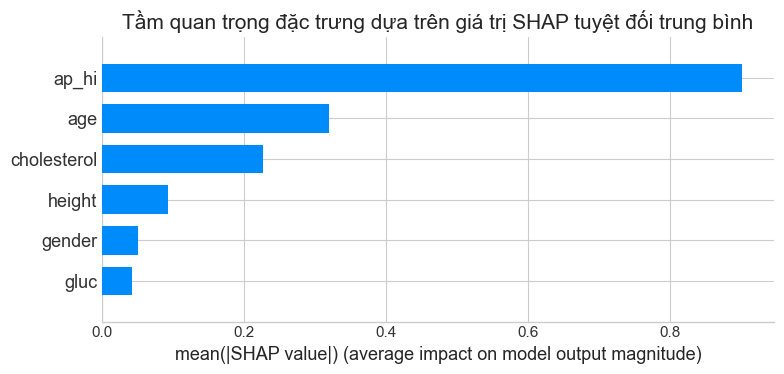

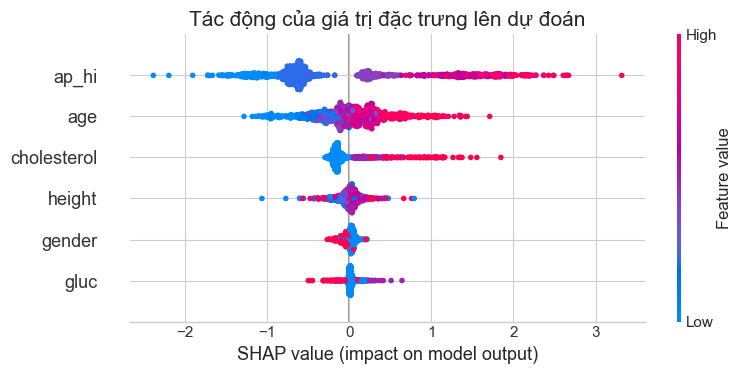


Top 3 đặc trưng quan trọng nhất theo SHAP: ap_hi, age, cholesterol


<Figure size 1200x800 with 0 Axes>

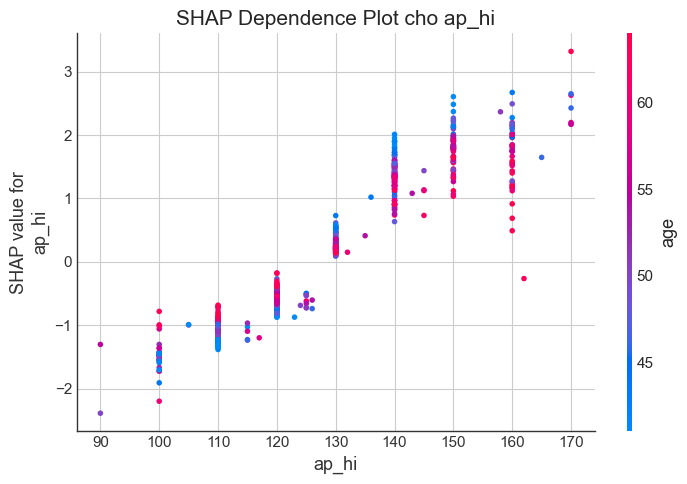

<Figure size 1200x800 with 0 Axes>

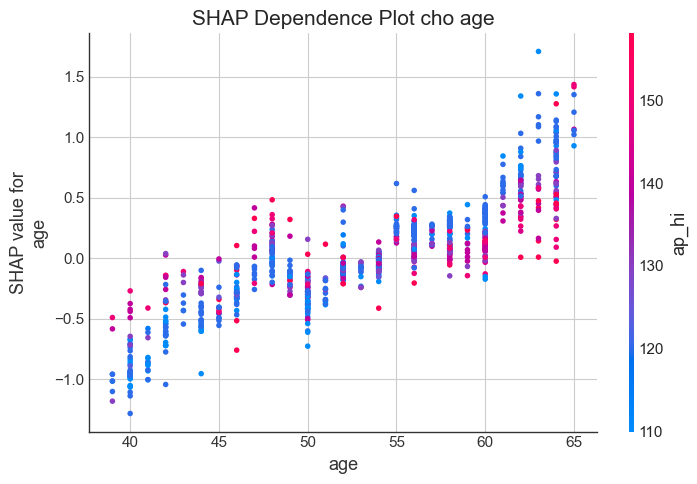

<Figure size 1200x800 with 0 Axes>

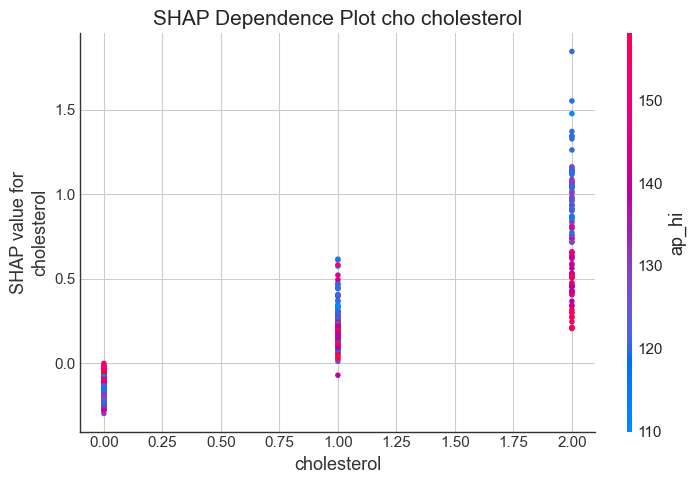

C:\Users\ADMIN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


<Figure size 2000x300 with 0 Axes>

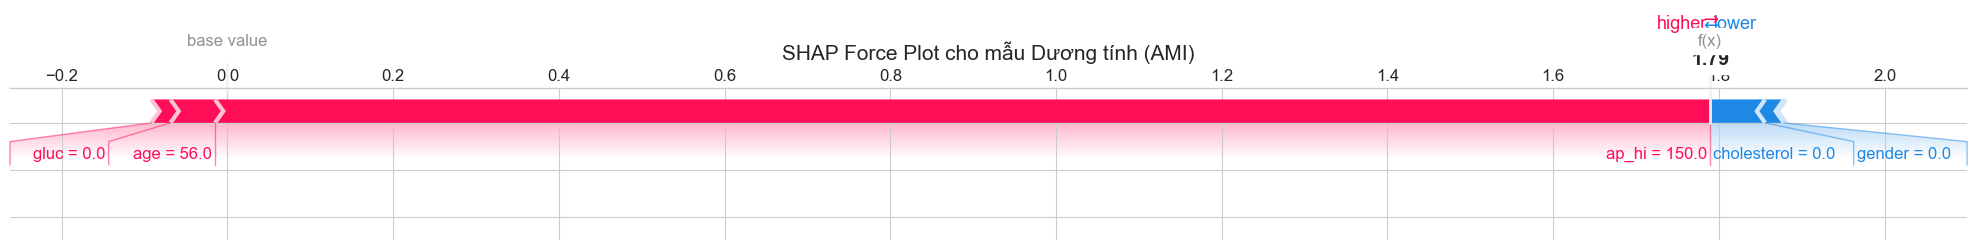

C:\Users\ADMIN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


<Figure size 2000x300 with 0 Axes>

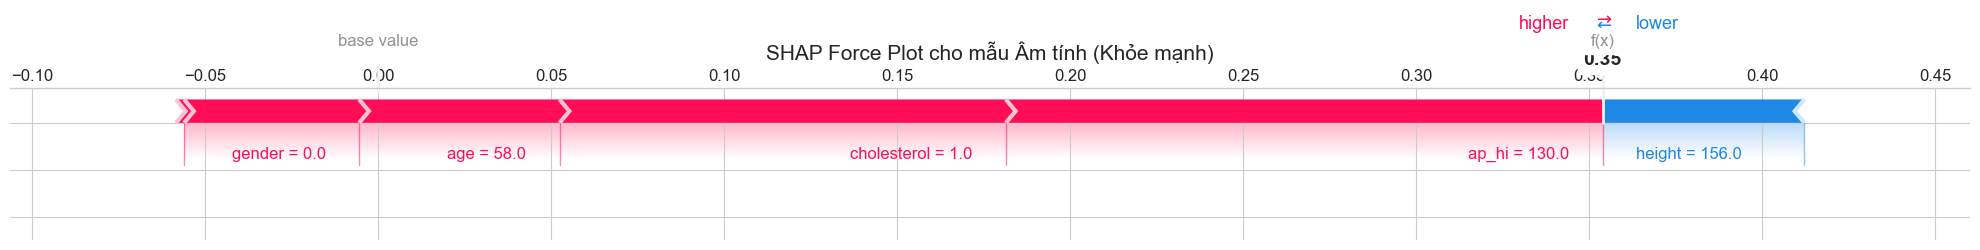

C:\Users\ADMIN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


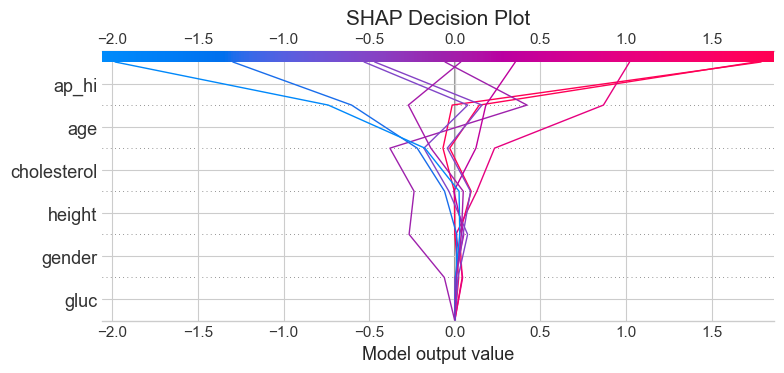


Tính toán tương tác SHAP giữa ap_hi và age...


<Figure size 1200x1000 with 0 Axes>

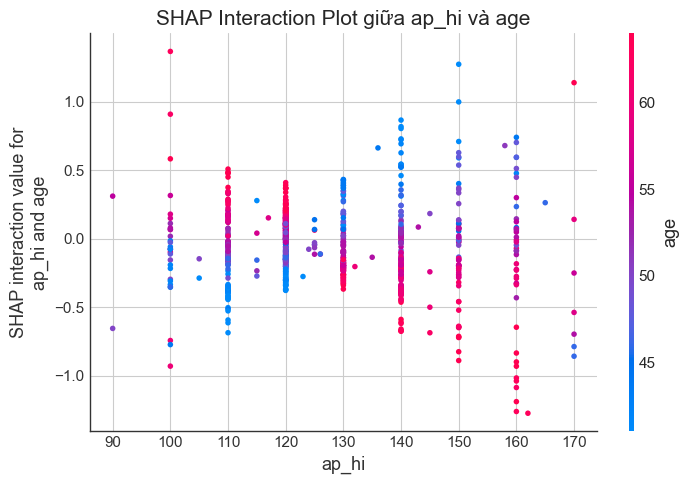

C:\Users\ADMIN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


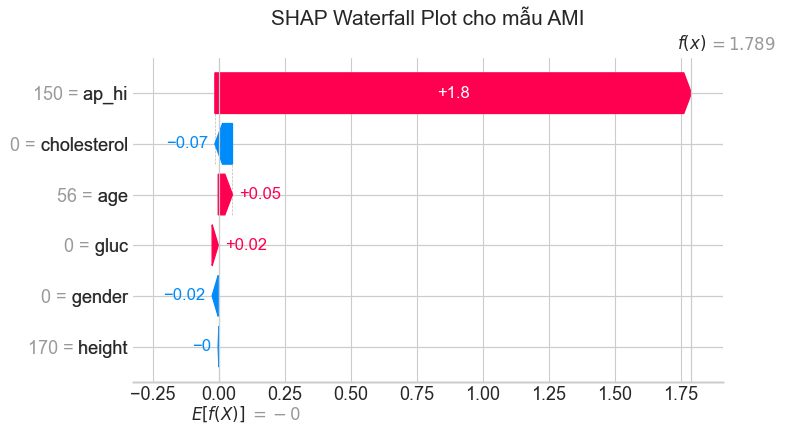

C:\Users\ADMIN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


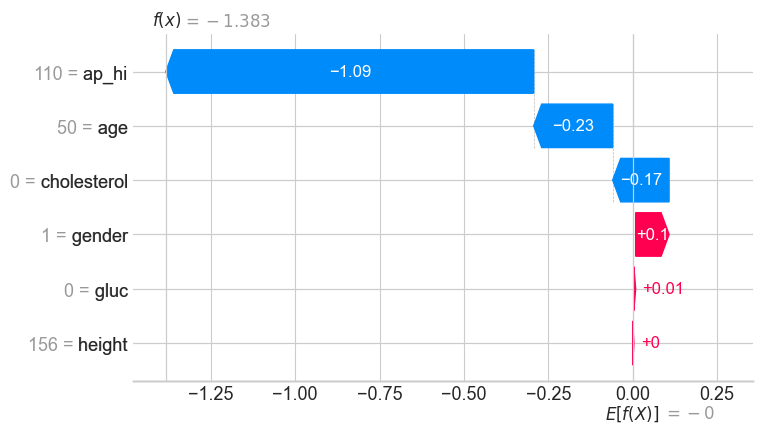

None


===== Báo cáo tổng quan SHAP =====
       Feature  SHAP Importance  Median Value  Q1 (25%)  Q3 (75%)
3        ap_hi         0.901664         120.0     120.0     140.0
0          age         0.319960          54.0      49.0      58.0
4  cholesterol         0.226257           0.0       0.0       0.0
2       height         0.092761         165.0     159.0     170.0
1       gender         0.050984           0.0       0.0       1.0
5         gluc         0.041832           0.0       0.0       0.0

Hoàn thành phân tích SHAP cho mô hình ACO-LGBM!


In [24]:
# ===== Áp dụng SHAP cho mô hình ACO-LGBM =====
print("\nÁp dụng SHAP để giải thích mô hình ACO-LGBM...")

# Khởi tạo SHAP explainer
explainer = shap.TreeExplainer(model)

# Tính giá trị SHAP cho tập kiểm tra (hoặc một mẫu nếu tập quá lớn)
# Nếu tập dữ liệu quá lớn, bạn có thể chọn một mẫu nhỏ hơn
if len(X_test) > 1000:
    print(f"Sử dụng mẫu 1000 dòng từ tập kiểm tra có {len(X_test)} dòng để tính giá trị SHAP...")
    X_sample = X_test.sample(1000, random_state=42)
    shap_values = explainer.shap_values(X_sample)
    X_shap = X_sample
else:
    shap_values = explainer.shap_values(X_test)
    X_shap = X_test

# In ra kích thước của giá trị SHAP
print(f"Kích thước giá trị SHAP: {np.array(shap_values).shape}")

# SHAP có thể tạo ra nhiều bộ giá trị cho các lớp khác nhau trong phân loại nhị phân
# Trong trường hợp này, chúng ta quan tâm đến lớp dương tính (AMI)
if isinstance(shap_values, list) and len(shap_values) > 1:
    print("SHAP đã tạo ra nhiều bộ giá trị cho các lớp khác nhau.")
    print(f"Số lượng lớp: {len(shap_values)}")
    # Chọn lớp dương tính (AMI)
    shap_values_class1 = shap_values[1]
else:
    shap_values_class1 = shap_values

# ===== Trực quan hóa SHAP =====

# 1. Biểu đồ tóm tắt SHAP
plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values_class1, X_shap, plot_type="bar", show=False)
plt.title('Tầm quan trọng đặc trưng dựa trên giá trị SHAP tuyệt đối trung bình', fontsize=15)
plt.tight_layout()
#plt.savefig('shap_importance_bar.png', dpi=300, bbox_inches='tight')
plt.show()

# 2. Biểu đồ tóm tắt SHAP chi tiết (beeswarm plot)
plt.figure(figsize=(14, 10))
shap.summary_plot(shap_values_class1, X_shap, show=False)
plt.title('Tác động của giá trị đặc trưng lên dự đoán', fontsize=15)
plt.tight_layout()
#plt.savefig('shap_summary_beeswarm.png', dpi=300, bbox_inches='tight')
plt.show()

# 3. SHAP dependence plots cho top 3 đặc trưng quan trọng nhất
# Tính tầm quan trọng trung bình tuyệt đối của từng đặc trưng
feature_importance = np.abs(shap_values_class1).mean(0)
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
})
top_features = feature_importance_df.sort_values('Importance', ascending=False).head(3)['Feature'].values

print(f"\nTop 3 đặc trưng quan trọng nhất theo SHAP: {', '.join(top_features)}")

for feature in top_features:
    plt.figure(figsize=(12, 8))
    feature_idx = feature_names.index(feature)
    shap.dependence_plot(feature_idx, shap_values_class1, X_shap, 
                       feature_names=feature_names, show=False)
    plt.title(f'SHAP Dependence Plot cho {feature}', fontsize=15)
    plt.tight_layout()
#   plt.savefig(f'shap_dependence_{feature}.png', dpi=300, bbox_inches='tight')
    plt.show()

# 4. SHAP force plot cho một mẫu cụ thể
# Chọn một mẫu dương tính và một mẫu âm tính để so sánh
positive_samples = y_test[y_test == 1].index
negative_samples = y_test[y_test == 0].index

if len(positive_samples) > 0 and len(negative_samples) > 0:
    # Lấy một mẫu của mỗi loại
    positive_idx = positive_samples[0]
    negative_idx = negative_samples[0]
    
    # Tạo SHAP force plot cho mẫu dương tính
    plt.figure(figsize=(20, 3))
    positive_sample = X_test.loc[positive_idx:positive_idx]
    if isinstance(shap_values, list) and len(shap_values) > 1:
        positive_shap = explainer.shap_values(positive_sample)[1]
    else:
        positive_shap = explainer.shap_values(positive_sample)
    
    shap.force_plot(explainer.expected_value[1] if isinstance(explainer.expected_value, list) 
                   else explainer.expected_value, 
                   positive_shap, positive_sample, 
                   feature_names=feature_names, matplotlib=True, show=False)
    plt.title('SHAP Force Plot cho mẫu Dương tính (AMI)', fontsize=15)
    plt.tight_layout()
#    plt.savefig('shap_force_plot_positive.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Tạo SHAP force plot cho mẫu âm tính
    plt.figure(figsize=(20, 3))
    negative_sample = X_test.loc[negative_idx:negative_idx]
    if isinstance(shap_values, list) and len(shap_values) > 1:
        negative_shap = explainer.shap_values(negative_sample)[1]
    else:
        negative_shap = explainer.shap_values(negative_sample)
    
    shap.force_plot(explainer.expected_value[1] if isinstance(explainer.expected_value, list) 
                   else explainer.expected_value, 
                   negative_shap, negative_sample, 
                   feature_names=feature_names, matplotlib=True, show=False)
    plt.title('SHAP Force Plot cho mẫu Âm tính (Khỏe mạnh)', fontsize=15)
    plt.tight_layout()
#    plt.savefig('shap_force_plot_negative.png', dpi=300, bbox_inches='tight')
    plt.show()

# 5. SHAP decision plot
if len(positive_samples) > 0 and len(negative_samples) > 0:
    # Lấy một số mẫu để minh họa
    n_samples = 5
    pos_samples = X_test.loc[positive_samples[:n_samples]]
    neg_samples = X_test.loc[negative_samples[:n_samples]]
    combined_samples = pd.concat([pos_samples, neg_samples])
    
    # Tính giá trị SHAP cho các mẫu này
    if isinstance(shap_values, list) and len(shap_values) > 1:
        combined_shap = explainer.shap_values(combined_samples)[1]
    else:
        combined_shap = explainer.shap_values(combined_samples)
    
    # Tạo nhãn để hiển thị trên biểu đồ
    combined_labels = ['Dương tính' if i < n_samples else 'Âm tính' for i in range(len(combined_samples))]
    
    # Tạo decision plot
    plt.figure(figsize=(12, 10))
    shap.decision_plot(explainer.expected_value[1] if isinstance(explainer.expected_value, list) 
                      else explainer.expected_value, 
                      combined_shap, combined_samples, 
                      feature_names=feature_names, show=False)
    plt.title('SHAP Decision Plot', fontsize=15)
    plt.tight_layout()
#    plt.savefig('shap_decision_plot.png', dpi=300, bbox_inches='tight')
    plt.show()

# 6. SHAP interaction plot
# Tính toán tương tác SHAP giữa các đặc trưng quan trọng nhất
if len(top_features) >= 2:
    feature1_idx = feature_names.index(top_features[0])
    feature2_idx = feature_names.index(top_features[1])
    
    # Tính giá trị tương tác SHAP (có thể mất nhiều thời gian với tập dữ liệu lớn)
    # Vì vậy, chúng ta sử dụng một mẫu nhỏ
    try:
        print(f"\nTính toán tương tác SHAP giữa {top_features[0]} và {top_features[1]}...")
        # Chọn một mẫu nhỏ để tính toán
        sample_size = min(1000, len(X_shap))
        X_sample_interaction = X_shap.sample(sample_size, random_state=42)
        shap_interaction_values = explainer.shap_interaction_values(X_sample_interaction)
        
        # Tạo biểu đồ tương tác
        plt.figure(figsize=(12, 10))
        shap.dependence_plot(
            (feature1_idx, feature2_idx), 
            shap_interaction_values, 
            X_sample_interaction,
            feature_names=feature_names,
            show=False
        )
        plt.title(f'SHAP Interaction Plot giữa {top_features[0]} và {top_features[1]}', fontsize=15)
        plt.tight_layout()
#       plt.savefig(f'shap_interaction_{top_features[0]}_{top_features[1]}.png', dpi=300, bbox_inches='tight')
        plt.show()
    except Exception as e:
        print(f"Không thể tạo biểu đồ tương tác SHAP: {e}")
        print("Bỏ qua biểu đồ tương tác SHAP.")

# 7. SHAP waterfall plot cho một mẫu cụ thể
if len(positive_samples) > 0:
    # Chọn một mẫu dương tính
    sample_idx = positive_samples[0]
    sample = X_test.loc[sample_idx:sample_idx]
    
    # Tính giá trị SHAP cho mẫu này
    if isinstance(shap_values, list) and len(shap_values) > 1:
        sample_shap = explainer.shap_values(sample)[1][0]
    else:
        sample_shap = explainer.shap_values(sample)[0]
    
    # Tạo waterfall plot
    plt.figure(figsize=(12, 10))
    shap.waterfall_plot(shap.Explanation(values=sample_shap, 
                                        base_values=explainer.expected_value[1] if isinstance(explainer.expected_value, list) else explainer.expected_value,
                                        data=sample.values[0], 
                                        feature_names=feature_names), 
                       show=False)
    plt.title('SHAP Waterfall Plot cho mẫu AMI', fontsize=15)
    plt.tight_layout()
#    plt.savefig('shap_waterfall_plot.png', dpi=300, bbox_inches='tight')
    plt.show()

# 8. Tạo SHAP Explanation Dashboard
try:
    import IPython.display as display
    # Chọn một mẫu ngẫu nhiên để hiển thị
    sample_idx = np.random.choice(len(X_test))
    sample = X_test.iloc[sample_idx:sample_idx+1]
    
    # Tính giá trị SHAP cho mẫu này
    if isinstance(shap_values, list) and len(shap_values) > 1:
        sample_shap = explainer.shap_values(sample)[1]
    else:
        sample_shap = explainer.shap_values(sample)
    
    # Tạo SHAP Explanation
    e = shap.Explanation(values=sample_shap, 
                        base_values=explainer.expected_value[1] if isinstance(explainer.expected_value, list) else explainer.expected_value, 
                        data=sample.values,
                        feature_names=feature_names)
    
    # Hiển thị dashboard
    display.display(shap.plots.waterfall(e[0]))
except Exception as e:
    print(f"Không thể tạo SHAP Explanation Dashboard: {e}")
    print("Bỏ qua SHAP Explanation Dashboard.")

# 9. Phân tích chi tiết SHAP cho từng lớp
if isinstance(shap_values, list) and len(shap_values) > 1:
    # Tính tầm quan trọng cho cả hai lớp
    class0_importance = np.abs(shap_values[0]).mean(0)
    class1_importance = np.abs(shap_values[1]).mean(0)
    
    # Tạo DataFrame so sánh
    comparison_df = pd.DataFrame({
        'Feature': feature_names,
        'Class 0 (Khỏe mạnh)': class0_importance,
        'Class 1 (AMI)': class1_importance
    })
    
    # Sắp xếp theo tầm quan trọng trung bình
    comparison_df['Average Importance'] = (comparison_df['Class 0 (Khỏe mạnh)'] + comparison_df['Class 1 (AMI)']) / 2
    comparison_df = comparison_df.sort_values('Average Importance', ascending=False)
    
    print("\nSo sánh tầm quan trọng đặc trưng giữa hai lớp:")
    print(comparison_df[['Feature', 'Class 0 (Khỏe mạnh)', 'Class 1 (AMI)']])
    
    # Biểu đồ so sánh tầm quan trọng cho hai lớp
    plt.figure(figsize=(12, 8))
    comparison_df_plot = comparison_df.copy()
    # Chỉ lấy top 7 đặc trưng quan trọng nhất để biểu đồ không quá đông đúc
    comparison_df_plot = comparison_df_plot.head(7)
    
    bar_width = 0.35
    x = np.arange(len(comparison_df_plot))
    
    plt.bar(x - bar_width/2, comparison_df_plot['Class 0 (Khỏe mạnh)'], 
            width=bar_width, label='Khỏe mạnh', color='skyblue')
    plt.bar(x + bar_width/2, comparison_df_plot['Class 1 (AMI)'], 
            width=bar_width, label='AMI', color='salmon')
    
    plt.xlabel('Đặc trưng')
    plt.ylabel('Tầm quan trọng SHAP trung bình')
    plt.title('So sánh tầm quan trọng SHAP giữa hai lớp')
    plt.xticks(x, comparison_df_plot['Feature'], rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
#    plt.savefig('shap_class_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

# 10. Tạo báo cáo SHAP tổng quan
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)
median_values = X_train.median()
q1_values = X_train.quantile(0.25)
q3_values = X_train.quantile(0.75)

# Tạo bảng báo cáo tổng hợp
report_df = pd.DataFrame({
    'Feature': feature_importance_df['Feature'],
    'SHAP Importance': feature_importance_df['Importance'],
    'Median Value': [median_values[f] for f in feature_importance_df['Feature']],
    'Q1 (25%)': [q1_values[f] for f in feature_importance_df['Feature']],
    'Q3 (75%)': [q3_values[f] for f in feature_importance_df['Feature']]
})

print("\n===== Báo cáo tổng quan SHAP =====")
print(report_df)

# Lưu báo cáo
#report_df.to_csv('shap_summary_report.csv', index=False)
#print("\nĐã lưu báo cáo tổng quan SHAP vào 'shap_summary_report.csv'")

print("\nHoàn thành phân tích SHAP cho mô hình ACO-LGBM!")